Using the cms_synthetic_claims.db from https://github.com/theradler/Hackathon25/tree/main/cms_synthetic_claims. Change the path to be your path

In [1]:
import pandas as pd
import sqlite3

# Connect to the local SQLite database
conn = sqlite3.connect('C:\\Workspace\\hack2\\Hackathon25-robert\\cms_synthetic_claims\\cms_synthetic_claims.db')

# Run the PRAGMA table_info command for each table
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
for table in tables['name']:
    info = pd.read_sql_query(f"PRAGMA table_info({table});", conn)
    print(f"Table: {table}")
    print(info)
    print()

df_inpatient_claims = pd.read_sql_query("SELECT * FROM raw_cms_claims;", conn)
conn.close()

Table: raw_cms_claims
     cid                         name       type  notnull dflt_value  pk
0      0                      BENE_ID    INTEGER        0       None   0
1      1                       CLM_ID    INTEGER        0       None   0
2      2   NCH_NEAR_LINE_REC_IDENT_CD       TEXT        0       None   0
3      3              NCH_CLM_TYPE_CD    INTEGER        0       None   0
4      4                  CLM_FROM_DT  TIMESTAMP        0       None   0
..   ...                          ...        ...      ...        ...  ..
192  192     CLM_UNCOMPD_CARE_PMT_AMT       REAL        0       None   0
193  193                 CLM_LINE_NUM    INTEGER        0       None   0
194  194                     REV_CNTR    INTEGER        0       None   0
195  195                     HCPCS_CD       TEXT        0       None   0
196  196  REV_CNTR_DDCTBL_COINSRNC_CD       REAL        0       None   0

[197 rows x 6 columns]

Table: raw_cms_beneficiary_2025
     cid               name       type  notnu

In [8]:
#  this removal process is slow, lets build up what we want to keep instead
# df_inpatient_claims = df_inpatient_claims.drop(columns=['NCH_NEAR_LINE_REC_IDENT_CD']) # always 'V' because this is inpatient claims
# df_inpatient_claims = df_inpatient_claims.drop(columns=['NCH_CLM_TYPE_CD']) # always 60 because this is inpatient claims
# df_inpatient_claims = df_inpatient_claims.drop(columns=['FI_CLM_PROC_DT']) # always empty, The date the fiscal intermediary completes processing and releases the institutional claim
# df_inpatient_claims = df_inpatient_claims.drop(columns=['CLAIM_QUERY_CODE']) # always 3 Code indicating the type of claim record being processed with respect to payment. 3 is the final bill
# df_inpatient_claims = df_inpatient_claims.drop(columns=['CLM_FAC_TYPE_CD']) # always 1, 'Hospital' https://bluebutton.cms.gov/resources/variables/clm_fac_type_cd/
# df_inpatient_claims = df_inpatient_claims.drop(columns=['CLM_SRVC_CLSFCTN_TYPE_CD']) # always 1, related to the above
# df_inpatient_claims = df_inpatient_claims.drop(columns=['CLM_FREQ_CD']) # always 1, Admit thru discharge claim, https://resdac.org/cms-data/variables/claim-frequency-code-ffs
# df_inpatient_claims = df_inpatient_claims.drop(columns=['FI_NUM']) # always blank https://resdac.org/cms-data/variables/fi-or-mac-number
# df_inpatient_claims = df_inpatient_claims.drop(columns=['CLM_MDCR_NON_PMT_RSN_CD']) # always blank https://resdac.org/cms-data/variables/claim-medicare-non-payment-reason-code

# Select a subset of columns to keep
columns_to_keep = [
    'BENE_ID', # unique beneficiary identifier
    'CLM_ID', # unique claim identifier
    'CLM_FROM_DT', # claim start date
    'CLM_THRU_DT', # claim through date
    'PRVDR_NUM', # provider identifier  number
    'CLM_PMT_AMT', # claim payment amount
    'NCH_PRMRY_PYR_CLM_PD_AMT', # amount paid by primary payer
    # 'FI_CLM_ACTN_CD', always blank The type of action requested by the intermediary to be taken on an institutional claim.
    'PRVDR_STATE_CD', # state code of the provider, not helpful really
    'ORG_NPI_NUM',  # The National Provider Identifier (NPI) of the organization or group practice.
    'AT_PHYSN_NPI', # Claim Attending Physician NPI Number
    'OP_PHYSN_NPI', # Claim Operating Physician NPI Number
    # 'OT_PHYSN_NPI', # Claim Other Physician NPI Number, always blank
    # 'PTNT_DSCHRG_STUS_CD', # Patient Discharge Status Code, always 1
    'CLM_TOT_CHRG_AMT',  # Claim Total Charge Amount
    'CLM_ADMSN_DT',  # Claim Admission Date
    'CLM_IP_ADMSN_TYPE_CD', # The code indicating the type and priority of an inpatient admission associated with the service on an intermediary submitted claim. 
    'CLM_SRC_IP_ADMSN_CD', # The code indicating the source of the referral for the admission or visit.
    'NCH_PTNT_STATUS_IND_CD', # The code indicating the source of the referral for the admission or visit.
    # 'CLM_PASS_THRU_PER_DIEM_AMT', always the same, Claim Pass Thru Per Diem Amount
    'NCH_BENE_IP_DDCTBL_AMT', # The amount of the deductible the beneficiary paid for inpatient services, as originally submitted on the institutional claim.
]

df_inpatient_subset = df_inpatient_claims[columns_to_keep].copy()

df_inpatient_subset.head()

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,PRVDR_STATE_CD,ORG_NPI_NUM,AT_PHYSN_NPI,OP_PHYSN_NPI,CLM_TOT_CHRG_AMT,CLM_ADMSN_DT,CLM_IP_ADMSN_TYPE_CD,CLM_SRC_IP_ADMSN_CD,NCH_PTNT_STATUS_IND_CD,NCH_BENE_IP_DDCTBL_AMT
0,-10000010254618,-10000930037831,2015-03-25 00:00:00,2015-03-25 00:00:00,11500,96.65,0.00,1,1578657367,9999870899,9999870899,96.65,2015-03-25 00:00:00,1,4,A,0.0
1,-10000010254653,-10000930038030,2015-09-24 00:00:00,2015-09-24 00:00:00,17129,6311.88,6276.88,1,1770717738,9999877191,9999877191,6311.88,2015-09-24 00:00:00,1,2,A,0.0
2,-10000010254653,-10000930038031,2017-05-09 00:00:00,2017-05-10 00:00:00,10052,8545.72,0.00,1,1598783904,9999995399,9999995399,8545.72,2017-05-09 00:00:00,3,1,A,0.0
3,-10000010254656,-10000930038162,2017-01-14 00:00:00,2017-01-14 00:00:00,15455,1014.85,979.85,1,1033215660,9999856690,9999856690,1014.85,2017-01-14 00:00:00,1,4,A,0.0
4,-10000010254656,-10000930038162,2017-01-14 00:00:00,2017-01-14 00:00:00,15455,1014.85,979.85,1,1033215660,9999856690,9999856690,1014.85,2017-01-14 00:00:00,1,4,A,0.0


In [9]:
df_inpatient_subset.describe()

,BENE_ID,CLM_ID,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,PRVDR_STATE_CD,ORG_NPI_NUM,AT_PHYSN_NPI,OP_PHYSN_NPI,CLM_TOT_CHRG_AMT,CLM_IP_ADMSN_TYPE_CD,CLM_SRC_IP_ADMSN_CD,NCH_BENE_IP_DDCTBL_AMT
count,5.806600e+04,5.806600e+04,58066.000000,58066.000000,58066.000000,5.806600e+04,5.806600e+04,5.806600e+04,58066.000000,58066.000000,58066.000000,58066.000000
mean,-1.000001e+13,-1.000093e+13,13638.307734,2732.677874,25.022767,1.506165e+09,9.999849e+09,9.999849e+09,13638.307734,1.499380,3.003668,9.590876
std,9.525039e+03,4.213611e+05,35993.907780,17139.230264,15.324945,2.919205e+08,1.820012e+05,1.820012e+05,35993.907780,0.856102,1.589491,84.713345
min,-1.000001e+13,-1.000093e+13,62.440000,0.000000,1.000000,1.003028e+09,9.999165e+09,9.999165e+09,62.440000,1.000000,1.000000,0.000000
25%,-1.000001e+13,-1.000093e+13,945.370000,0.000000,10.000000,1.265846e+09,9.999799e+09,9.999799e+09,945.370000,1.000000,1.000000,0.000000
50%,-1.000001e+13,-1.000093e+13,1481.715000,0.000000,24.000000,1.538146e+09,9.999904e+09,9.999904e+09,1481.715000,1.000000,4.000000,0.000000
75%,-1.000001e+13,-1.000093e+13,9932.040000,0.000000,37.000000,1.750310e+09,9.999980e+09,9.999980e+09,9932.040000,2.000000,5.000000,0.000000
max,-1.000001e+13,-1.000093e+13,598716.310000,598077.270000,53.000000,1.992971e+09,1.000000e+10,1.000000e+10,598716.310000,3.000000,5.000000,1644.000000


Matplotlib is building the font cache; this may take a moment.


array([[<Axes: title={'center': 'CLM_PMT_AMT'}>]], dtype=object)

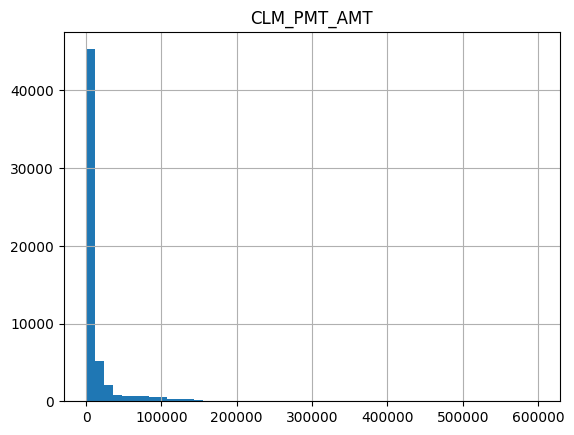

In [13]:
import matplotlib.pyplot as plt

df_inpatient_subset.hist(column='CLM_PMT_AMT', bins=50)